In [1]:
import matplotlib.pyplot as plt
import os, re, pickle
import scipy.io
from collections import defaultdict
import numpy as np

import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))

color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "purple",
    "DET-GrpE vs FullGradCam":  "cyan",
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",
}

alpha = 0.3

### Whole-Image Human Attention Maps

In [2]:
human_attention_path = {
    "DET":{
        'vehicle': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh DET/whole_image',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum DET/whole_image',
    },
    "DET-GrpF":{
        'vehicle':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh DET/grp1',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum DET/grp1',
    },
    "DET-GrpE":{
        'vehicle':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh DET/grp2',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum DET/grp2',
    },
    # "DET-Cropped":{
    #     'vehicle': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/231206 Veh DET/cropped',
    #     'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/231206 Hum DET/cropped',
    # },
    "EXP":{
        'vehicle':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/results/explanation/231018_vehicle_whole_screen_vb_fixed_pos/human_saliency_map',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/results/explanation/231018_human_whole_screen_vb_fixed_pos/human_saliency_map',
    },
    "EXP-GrpF":{
        'vehicle':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP/grp1',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP/grp2', #NOTE: flip grp order to have a consistent EF naming
    },
    "EXP-GrpE":{
        'vehicle':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP/grp2',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP/grp1', #NOTE: flip grp order to have a consistent EF naming
    },
}

# Attention Type, Category, Image Idex
human_attention = {
    "DET": defaultdict(defaultdict),
    "DET-GrpF": defaultdict(defaultdict),
    "DET-GrpE": defaultdict(defaultdict),
    # "DET-Cropped": defaultdict(defaultdict),
    "EXP": defaultdict(defaultdict),
    "EXP-GrpF": defaultdict(defaultdict),
    "EXP-GrpE": defaultdict(defaultdict),
}

for type, path_by_type in human_attention_path.items():
    for category, path in path_by_type.items():
        for file in os.listdir(path):
            img_idx = re.findall(r'\d+',file)[0]
            mat = scipy.io.loadmat(os.path.join(path,file))
            human_attention[type][category][img_idx] = mat['output_map_norm']

In [3]:
# check I didn't enter duplicate paths
check_paths = set()
for type, path_by_type in human_attention_path.items():
    for category, path in path_by_type.items():
        check_paths.add(path)

print(len(check_paths))

12


In [4]:
human_attention[type]['vehicle'].keys()

dict_keys(['1007', '100', '1023', '1026', '1028', '1031', '1041', '1043', '1047', '1065', '1079', '1090', '1099', '1100', '1108', '1109', '1112', '1114', '1121', '1127', '113', '1145', '1149', '1170', '1178', '117', '1183', '1201', '1209', '1211', '1223', '1226', '1232', '1236', '1252', '1253', '1258', '126', '1272', '1278', '1319', '1331', '133', '1344', '134', '1353', '1356', '1357', '1365', '141', '171', '178', '180', '183', '188', '192', '209', '210', '222', '241', '245', '269', '273', '274', '293', '297', '30', '321', '327', '329', '33', '342', '344', '355', '362', '36', '376', '381', '383', '388', '390', '3', '401', '406', '407', '425', '431', '437', '441', '447', '452', '478', '485', '49', '503', '505', '514', '52', '542', '54', '559', '570', '585', '600', '610', '611', '617', '629', '634', '648', '668', '66', '670', '67', '68', '692', '698', '699', '711', '715', '727', '740', '74', '758', '764', '777', '784', '796', '797', '803', '804', '822', '833', '838', '842', '843', '848',

In [4]:
for type, t in human_attention.items():
    for category, c in t.items():
        # for layer, l in c.items():
            print(f"{type}  {category} {len(c)}")

DET  vehicle 160
DET  human 160
DET-GrpF  vehicle 160
DET-GrpF  human 160
DET-GrpE  vehicle 160
DET-GrpE  human 160
EXP  vehicle 160
EXP  human 160
EXP-GrpF  vehicle 160
EXP-GrpF  human 160
EXP-GrpE  vehicle 160
EXP-GrpE  human 160


In [5]:
failed_imgs = defaultdict(list)

In [6]:
xai_saliency_path = {
    "FullGradCAM":{
        'vehicle': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer_faster/fullgradcamraw_vehicle',
        'human': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer_faster/fullgradcamraw_human',
    },
    "ODAM":{
        'vehicle': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer_faster/odam_vehicle',
        'human' : '/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer_faster/odam_human',
    }
}

# Type, Category, Layer, Image
xai_saliency_maps = {
    "FullGradCAM":{
        'vehicle': defaultdict(defaultdict),
        'human': defaultdict(defaultdict),
    },
    "ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    }
}

for type, path_by_type in xai_saliency_path.items():
    for category, path in path_by_type.items():
        for dir in os.listdir(path):
            layer_num = int(re.findall(r"F\d+",dir)[-1].replace('F',''))

            for file in os.listdir(os.path.join(path,dir)):
                if '.mat' not in file: continue
                img_idx = re.findall(r'\d+-',file)[-1].replace('-','')
                mat = scipy.io.loadmat(os.path.join(path,dir,file))
                if mat['masks_ndarray'].sum()==1.5 and mat['masks_ndarray'][0,0]==1 and mat['masks_ndarray'][1,1]==0.5:
                    failed_imgs[category].append(img_idx)
                    continue
                elif not np.any(mat['masks_ndarray']):
                    failed_imgs[category].append(img_idx)
                    continue
                xai_saliency_maps[type][category][layer_num][img_idx] = mat['masks_ndarray']
                # print(f"{category}\t{type}\t{layer_num}\t{file}")

In [9]:
for type, path_by_type in xai_saliency_path.items():
    for category, path in path_by_type.items():
        if not (type=='ODAM' and category=='human'): continue
        for dir in os.listdir(path):
            layer_num = int(re.findall(r"F\d+",dir)[-1].replace('F',''))

            for file in os.listdir(os.path.join(path,dir)):
                if '.mat' not in file: continue
                img_idx = re.findall(r'\d+-',file)[-1].replace('-','')
                mat = scipy.io.loadmat(os.path.join(path,dir,file))
                if mat['masks_ndarray'].sum()==1.5 and mat['masks_ndarray'][0,0]==1 and mat['masks_ndarray'][1,1]==0.5:
                    failed_imgs[category].append(img_idx)
                    continue
                elif not np.any(mat['masks_ndarray']):
                    failed_imgs[category].append(img_idx)
                    continue
                xai_saliency_maps[type][category][layer_num][img_idx] = mat['masks_ndarray']
                # print(f"{category}\t{type}\t{layer_num}\t{file}")

In [10]:
print(len(set(failed_imgs['vehicle'])))
print(len(set(failed_imgs['human'])))

46
58


In [46]:
np.any(xai_saliency_maps[type][category][layer_num][img_idx])

True

In [27]:
human_attention['DET']['vehicle'].keys()

dict_keys(['1007', '100', '1023', '1026', '1028', '1031', '1041', '1043', '1047', '1065', '1079', '1090', '1099', '1100', '1108', '1109', '1112', '1114', '1121', '1127', '113', '1145', '1149', '1170', '1178', '117', '1183', '1201', '1209', '1211', '1223', '1226', '1232', '1236', '1252', '1253', '1258', '126', '1272', '1278', '1319', '1331', '133', '1344', '134', '1353', '1356', '1357', '1365', '141', '171', '178', '180', '183', '188', '192', '209', '210', '222', '241', '245', '269', '273', '274', '293', '297', '30', '321', '327', '329', '33', '342', '344', '355', '362', '36', '376', '381', '383', '388', '390', '3', '401', '406', '407', '425', '431', '437', '441', '447', '452', '478', '485', '49', '503', '505', '514', '52', '542', '54', '559', '570', '585', '600', '610', '611', '617', '629', '634', '648', '668', '66', '670', '67', '68', '692', '698', '699', '711', '715', '727', '740', '74', '758', '764', '777', '784', '796', '797', '803', '804', '822', '833', '838', '842', '843', '848',

In [11]:
with open("missing_layer","w") as f:
        for type, t in xai_saliency_maps.items():
                for category, c in t.items():
                        f.write(category+"\n")
                        print(category)
                        for layer, l in c.items():
                                f.write(f"{type} Layer {layer} {len(l)}\n")
                                print(f"{type} Layer {layer} {len(l)}")
                        #     for img in human_attention['DET'][category]:
                                #    if img not in l:
                                #           print(img)

vehicle
FullGradCAM Layer 10 160
FullGradCAM Layer 11 160
FullGradCAM Layer 12 160
FullGradCAM Layer 13 160
FullGradCAM Layer 14 160
FullGradCAM Layer 15 160
FullGradCAM Layer 16 160
FullGradCAM Layer 17 160
FullGradCAM Layer 1 160
FullGradCAM Layer 2 160
FullGradCAM Layer 3 160
FullGradCAM Layer 4 160
FullGradCAM Layer 5 160
FullGradCAM Layer 6 160
FullGradCAM Layer 7 160
FullGradCAM Layer 8 160
FullGradCAM Layer 9 160
human
FullGradCAM Layer 10 160
FullGradCAM Layer 11 160
FullGradCAM Layer 12 160
FullGradCAM Layer 13 160
FullGradCAM Layer 14 160
FullGradCAM Layer 15 160
FullGradCAM Layer 16 160
FullGradCAM Layer 17 159
FullGradCAM Layer 1 160
FullGradCAM Layer 2 160
FullGradCAM Layer 3 160
FullGradCAM Layer 4 160
FullGradCAM Layer 5 160
FullGradCAM Layer 6 160
FullGradCAM Layer 7 160
FullGradCAM Layer 8 160
FullGradCAM Layer 9 160
vehicle
ODAM Layer 10 114
ODAM Layer 11 114
ODAM Layer 12 114
ODAM Layer 13 114
ODAM Layer 14 112
ODAM Layer 15 113
ODAM Layer 16 114
ODAM Layer 17 114
OD

## Similarity Analysis

In [7]:
zero_pcc = {
    "DET vs FullGradCam":{
        'vehicle': defaultdict(list),
        'human': defaultdict(list),
    },
    "DET-GrpF vs FullGradCam":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "DET-GrpE vs FullGradCam":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "EXP vs ODAM":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "EXP-GrpF vs ODAM":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "EXP-GrpE vs ODAM":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
}

negative_pcc = {
    "DET vs FullGradCam":{
        'vehicle': defaultdict(list),
        'human': defaultdict(list),
    },
    "DET-GrpF vs FullGradCam":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "DET-GrpE vs FullGradCam":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "EXP vs ODAM":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "EXP-GrpF vs ODAM":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
    "EXP-GrpE vs ODAM":{
        'vehicle': defaultdict(list),
        'human' : defaultdict(list),
    },
}

In [12]:
PCC_all = {
    "DET vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human': defaultdict(defaultdict),
    },
    "DET-GrpF vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "DET-GrpE vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP-GrpF vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP-GrpE vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
}
RMSE_all = {
    "DET vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human': defaultdict(defaultdict),
    },
    "DET-GrpF vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "DET-GrpE vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP-GrpF vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP-GrpE vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
}

for category in ['vehicle','human']:
    for layer in range(1,18):
        for img in human_attention['DET'][category].keys():
            if img in set(failed_imgs[category]): continue

            if img in xai_saliency_maps['FullGradCAM'][category][layer].keys():
                # DET vs FullGradCam
                PCC_all['DET vs FullGradCam'][category][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET'][category][img].flatten())[0,1]
                RMSE_all['DET vs FullGradCam'][category][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET'][category][img].flatten())
                if PCC_all['DET vs FullGradCam'][category][layer][img] == 0:
                    zero_pcc['DET vs FullGradCam'][category][layer].append(img)
                elif PCC_all['DET vs FullGradCam'][category][layer][img] < 0:
                    negative_pcc['DET vs FullGradCam'][category][layer].append(img)
                
                # DET-GrpF vs ODAM
                PCC_all['DET-GrpF vs FullGradCam'][category][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET-GrpF'][category][img].flatten())[0,1]
                RMSE_all['DET-GrpF vs FullGradCam'][category][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET-GrpF'][category][img].flatten())
                if PCC_all['DET-GrpF vs FullGradCam'][category][layer][img] == 0:
                    zero_pcc['DET-GrpF vs FullGradCam'][category][layer].append(img)
                elif PCC_all['DET-GrpF vs FullGradCam'][category][layer][img] < 0:
                    negative_pcc['DET-GrpF vs FullGradCam'][category][layer].append(img)

                # DET-GrpE vs ODAM
                PCC_all['DET-GrpE vs FullGradCam'][category][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET-GrpE'][category][img].flatten())[0,1]
                RMSE_all['DET-GrpE vs FullGradCam'][category][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET-GrpE'][category][img].flatten())
                if PCC_all['DET-GrpE vs FullGradCam'][category][layer][img] == 0:
                    zero_pcc['DET-GrpE vs FullGradCam'][category][layer].append(img)
                elif PCC_all['DET-GrpE vs FullGradCam'][category][layer][img] < 0:
                    negative_pcc['DET-GrpE vs FullGradCam'][category][layer].append(img)

            if img in xai_saliency_maps['ODAM'][category][layer].keys():
                # EXP vs ODAM
                PCC_all['EXP vs ODAM'][category][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP'][category][img].flatten())[0,1]
                RMSE_all['EXP vs ODAM'][category][layer][img] = RMSE(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP'][category][img].flatten())
                if PCC_all['EXP vs ODAM'][category][layer][img] == 0:
                    zero_pcc['EXP vs ODAM'][category][layer].append(img)
                elif PCC_all['EXP vs ODAM'][category][layer][img] < 0:
                    negative_pcc['EXP vs ODAM'][category][layer].append(img)

                # EXP-GrpF vs ODAM
                PCC_all['EXP-GrpF vs ODAM'][category][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP-GrpF'][category][img].flatten())[0,1]
                RMSE_all['EXP-GrpF vs ODAM'][category][layer][img] = RMSE(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP-GrpF'][category][img].flatten())
                if PCC_all['EXP-GrpF vs ODAM'][category][layer][img] == 0:
                    zero_pcc['EXP-GrpF vs ODAM'][category][layer].append(img)
                elif PCC_all['EXP-GrpF vs ODAM'][category][layer][img] < 0:
                    negative_pcc['EXP-GrpF vs ODAM'][category][layer].append(img)


                # EXP-GrpE vs ODAM
                PCC_all['EXP-GrpE vs ODAM'][category][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP-GrpE'][category][img].flatten())[0,1]
                RMSE_all['EXP-GrpE vs ODAM'][category][layer][img] = RMSE(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP-GrpE'][category][img].flatten())
                if PCC_all['EXP-GrpE vs ODAM'][category][layer][img] == 0:
                    zero_pcc['EXP-GrpE vs ODAM'][category][layer].append(img)
                elif PCC_all['EXP-GrpE vs ODAM'][category][layer][img] < 0:
                    negative_pcc['EXP-GrpE vs ODAM'][category][layer].append(img)

In [13]:
pickle.dump(PCC_all, open('/mnt/h/jinhan/xai/results/bdd/faster_rcnn/bdd_PCC_all.pickle','wb'))
pickle.dump(RMSE_all, open('/mnt/h/jinhan/xai/results/bdd/faster_rcnn/bdd_RMSE_all.pickle','wb'))

In [2]:
PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/faster_rcnn/bdd_PCC_all.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/faster_rcnn/bdd_PCC_all.pickle','rb'))

In [3]:
PCC_layer_mean = defaultdict(defaultdict)
RMSE_layer_mean = defaultdict(defaultdict)

for analysis in PCC_all.keys():
    for category in ['vehicle','human']:
        PCC_layer_mean[analysis][category] = pd.DataFrame.from_dict(PCC_all[analysis][category]).mean(axis=0)
        RMSE_layer_mean[analysis][category] = pd.DataFrame.from_dict(RMSE_all[analysis][category]).mean(axis=0)

In [3]:
p_values = defaultdict(lambda: defaultdict(list))

neck_pcc_all = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
backbone_pcc_all = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
neck_pcc = defaultdict(lambda: defaultdict(list))
backbone_pcc = defaultdict(lambda: defaultdict(list))
for analysis, d0 in PCC_all.items():
    for category, d1 in d0.items():
        print()
        print(f"{category} {analysis}")
        for layer, d2 in d1.items():
            for img, pcc in d2.items():
                if layer in range(9,18):
                    backbone_pcc_all[category][analysis][img].append(pcc)
                elif layer in range(5,9):
                    neck_pcc_all[category][analysis][img].append(pcc)

        for img in backbone_pcc_all[category][analysis].keys():
            backbone_pcc[category][analysis].append(np.average(backbone_pcc_all[category][analysis][img]))
            neck_pcc[category][analysis].append(np.average(neck_pcc_all[category][analysis][img]))

        result = scipy.stats.ttest_rel(neck_pcc[category][analysis], backbone_pcc[category][analysis])
        print(f"t({len(PCC_all[analysis][category][12]-1)})={np.format_float_positional(result.statistic,precision=3, unique=False, fractional=False, trim='k')}, p={np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k')}")
        print(f"Backbone: M={np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}")
        print(f"Neck: M={np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}")

        p_values[category][analysis] = float(np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k'))


vehicle DET vs FullGradCam
t(86)=0.299, p=0.766
Backbone: M=0.456, std=0.135
Neck: M=0.459, std=0.147

human DET vs FullGradCam
t(68)=1.63, p=0.108
Backbone: M=0.392, std=0.114
Neck: M=0.406, std=0.136

vehicle DET-GrpF vs FullGradCam
t(86)=0.281, p=0.78
Backbone: M=0.453, std=0.135
Neck: M=0.456, std=0.149

human DET-GrpF vs FullGradCam
t(68)=1.89, p=0.0627
Backbone: M=0.385, std=0.113
Neck: M=0.402, std=0.136

vehicle DET-GrpE vs FullGradCam
t(86)=0.442, p=0.66
Backbone: M=0.428, std=0.133
Neck: M=0.432, std=0.136

human DET-GrpE vs FullGradCam
t(68)=-0.439, p=0.662
Backbone: M=0.368, std=0.127
Neck: M=0.364, std=0.149

vehicle EXP vs ODAM
t(86)=4.33, p=0.0000402
Backbone: M=0.521, std=0.116
Neck: M=0.579, std=0.153

human EXP vs ODAM
t(68)=6.86, p=0.00000000273
Backbone: M=0.516, std=0.0715
Neck: M=0.595, std=0.0838

vehicle EXP-GrpF vs ODAM
t(86)=4.63, p=0.000013
Backbone: M=0.519, std=0.118
Neck: M=0.583, std=0.155

human EXP-GrpF vs ODAM
t(68)=6.82, p=0.00000000318
Backbone: M=0

In [28]:
p_values['vehicle']['EXP vs ODAM']

0.00149

In [4]:
PCC_sorted = defaultdict(defaultdict)
RMSE_sorted = defaultdict(defaultdict)

for analysis in PCC_all.keys():
    for category in ['vehicle','human']:
        PCC_sorted[analysis][category] = PCC_layer_mean[analysis][category].sort_index()[::-1]
        RMSE_sorted[analysis][category] = RMSE_layer_mean[analysis][category].sort_index()[::-1]

## 2_layer paired t test

In [8]:
threshold = 0.05

focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']
change_points = {
    "vehicle":defaultdict(list),
    "human": defaultdict(list)# list of change point index (1-based layer number before the change)
    }
results = {
    "vehicle":defaultdict(defaultdict),
    "human": defaultdict(defaultdict)# result of each pair-wise comparison
    }

for type in ['vehicle','human']:
    for analysis in focused_analysis:
        layers = list(PCC_all[analysis].keys())
        for l in range(5,17):
            # Check: image order the same in both layers
            result = scipy.stats.ttest_rel(list(PCC_all[analysis][type][l].values()), list(PCC_all[analysis][type][l+1].values()))
            results[type][analysis][l] = result

            if result.pvalue <= threshold:
                change_points[type][analysis].append(l)


In [9]:
change_points

{'vehicle': defaultdict(list,
             {'DET vs FullGradCam': [5, 7, 10, 11],
              'EXP vs ODAM': [5, 10, 11, 14, 16]}),
 'human': defaultdict(list,
             {'DET vs FullGradCam': [5, 7, 9, 10, 11, 14, 15],
              'EXP vs ODAM': [5, 6, 7, 9, 10, 11, 13, 14]})}

## Plot layers

In [17]:
color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "purple",
    "DET-GrpE vs FullGradCam":  "cyan",
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",
}

alpha = 0.3

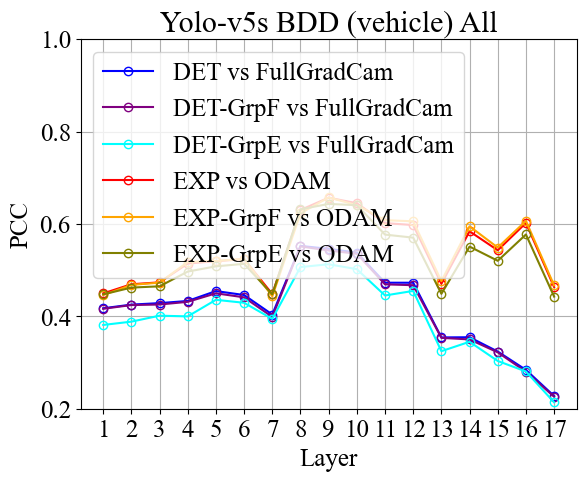

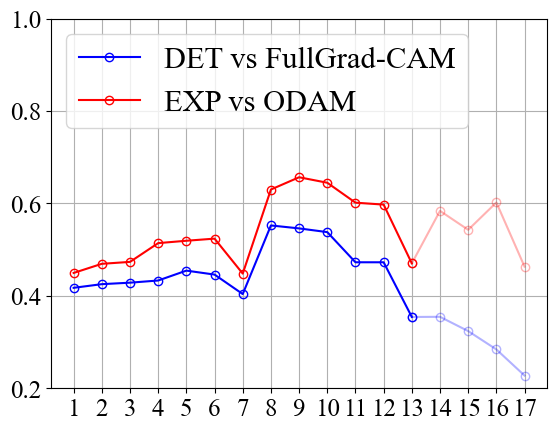

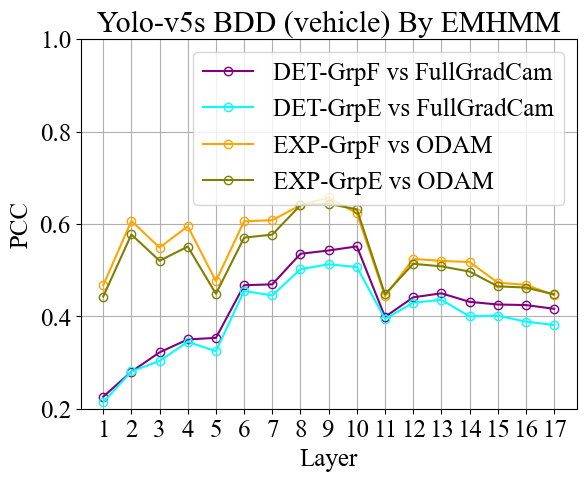

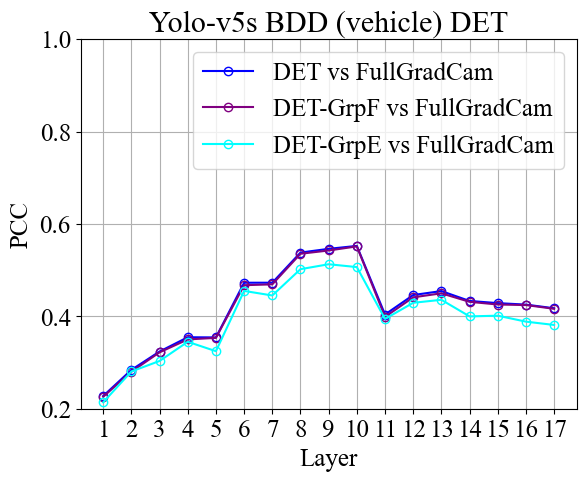

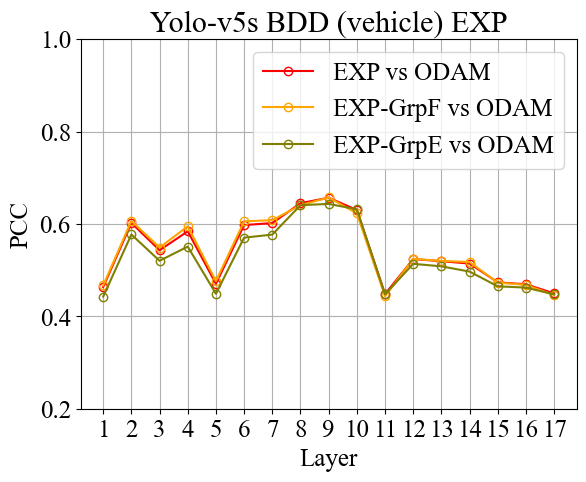

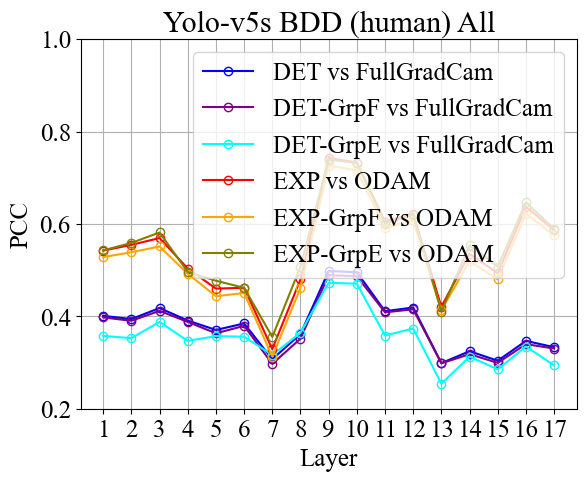

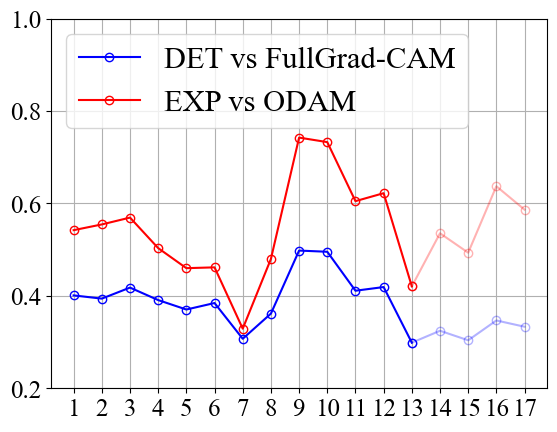

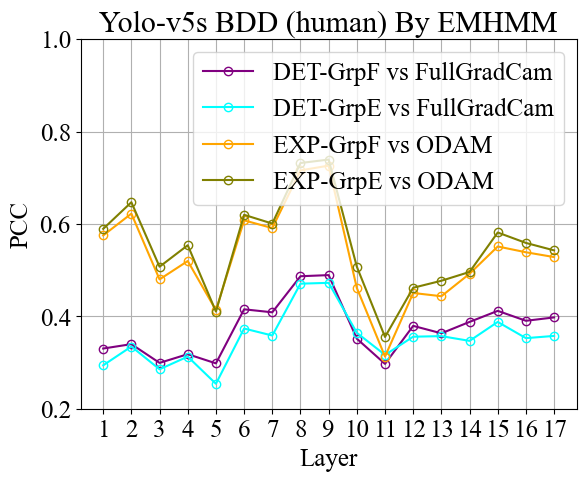

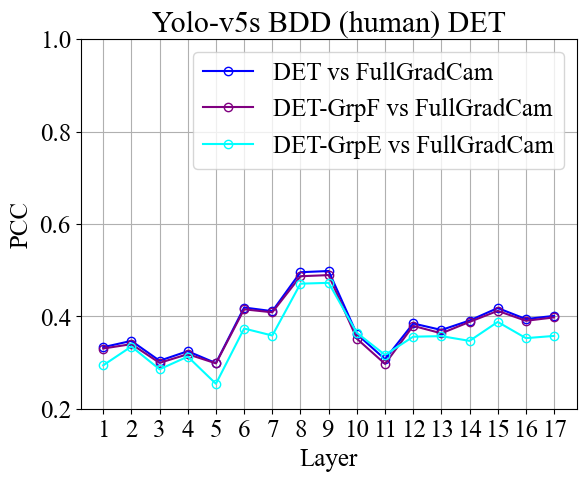

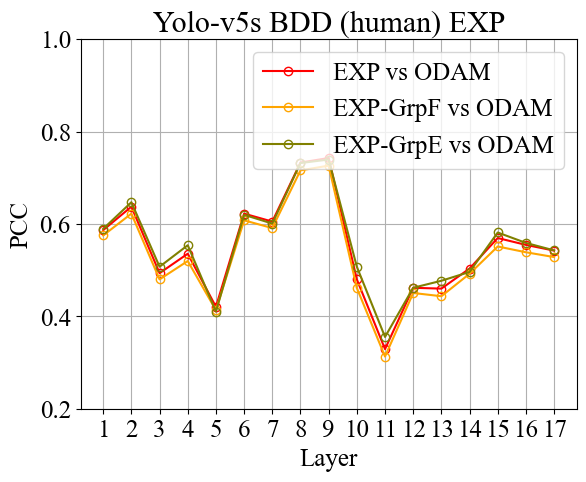

In [83]:
ylims = {
    'vehicle': (0.2,1),
    'human': (0.2,1)
}

for category in ['vehicle','human']:

    #All in one
    plt.figure()
    plt.grid()
    plt.xlabel('Layer')
    plt.ylabel('PCC')
    for analysis in PCC_all.keys():
        plt.plot(PCC_sorted[analysis][category].index[::-1], PCC_sorted[analysis][category].values, marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
    plt.xticks(PCC_sorted[analysis][category].index[::-1])
    plt.ylim(ylims[category])
    plt.title(f"Yolo-v5s BDD ({category}) All")
    plt.legend()
    plt.savefig(f'/mnt/h/jinhan/xai/results/bdd/{category}_all')
    plt.show()

    # Overall similarity
    plt.figure()
    plt.grid()
    # plt.xlabel('Layer')
    # plt.ylabel('PCC')
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 18
    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        plt.plot(PCC_sorted[analysis][category].index[::-1][0:13], PCC_sorted[analysis][category].values[0:13], marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
    plt.xticks(PCC_sorted[analysis][category].index[::-1])
    plt.ylim(ylims[category])
    # plt.title(f"Yolo-v5s BDD ({category}) By Tasks")
    plt.legend(labels=['DET vs FullGrad-CAM','EXP vs ODAM','PV vs FullGrad-CAM'], fontsize=22, loc='upper left')
    for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        plt.plot(PCC_sorted[analysis][category].index[::-1][12:18], PCC_sorted[analysis][category].values[12:18], marker='o',fillstyle='none',c=color_code[analysis],alpha=alpha)
    plt.savefig(f'/mnt/h/jinhan/xai/results/bdd/{category}_by_tasks',
                dpi=300)
    plt.show()

    # Grouped by EMHMM
    plt.figure()
    plt.grid()
    plt.xlabel('Layer')
    plt.ylabel('PCC')
    for analysis in ['DET-GrpF vs FullGradCam','DET-GrpE vs FullGradCam','EXP-GrpF vs ODAM', 'EXP-GrpE vs ODAM']:
        plt.plot(PCC_sorted[analysis][category].index, PCC_sorted[analysis][category].values, marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
    plt.xticks(PCC_sorted[analysis][category].index)
    plt.ylim(ylims[category])
    plt.title(f"Yolo-v5s BDD ({category}) By EMHMM")
    plt.legend()
    plt.savefig(f'/mnt/h/jinhan/xai/results/bdd/{category}_by_emhmm')
    plt.show()

    # DET
    plt.figure()
    plt.grid()
    plt.xlabel('Layer')
    plt.ylabel('PCC')
    for analysis in ['DET vs FullGradCam','DET-GrpF vs FullGradCam','DET-GrpE vs FullGradCam']:
        plt.plot(PCC_sorted[analysis][category].index, PCC_sorted[analysis][category].values, marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
    plt.xticks(PCC_sorted[analysis][category].index)
    plt.ylim(ylims[category])
    plt.title(f"Yolo-v5s BDD ({category}) DET")
    plt.legend()
    plt.savefig(f'/mnt/h/jinhan/xai/results/bdd/{category}_DET')
    plt.show()

    # EXP
    plt.figure()
    plt.grid()
    plt.xlabel('Layer')
    plt.ylabel('PCC')
    for analysis in ['EXP vs ODAM','EXP-GrpF vs ODAM','EXP-GrpE vs ODAM']:
        plt.plot(PCC_sorted[analysis][category].index, PCC_sorted[analysis][category].values, marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
    plt.xticks(PCC_sorted[analysis][category].index)
    plt.ylim(ylims[category])
    plt.title(f"Yolo-v5s BDD ({category}) EXP")
    plt.legend()
    plt.savefig(f'/mnt/h/jinhan/xai/results/bdd/{category}_EXP')
    plt.show()

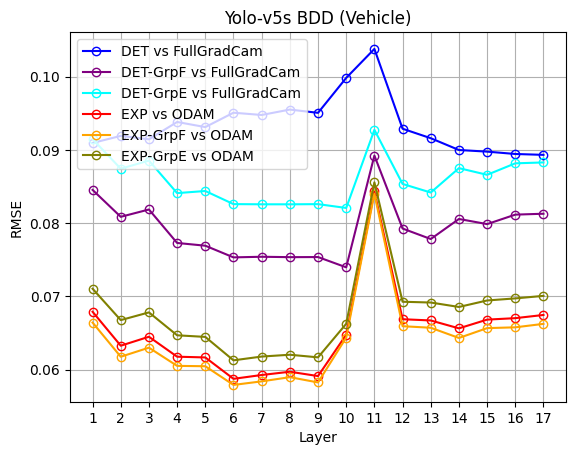

In [15]:
# Vehicle
plt.figure()
for analysis in RMSE_all.keys():
    plt.plot(RMSE_sorted[analysis]['vehicle'].index, RMSE_sorted[analysis]['vehicle'].values, marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
# plt.ylim((0.2,0.8))
plt.xticks(RMSE_sorted[analysis]['vehicle'].index)
plt.grid()
plt.legend()
plt.xlabel('Layer')
plt.ylabel('RMSE')
plt.title("Yolo-v5s BDD (Vehicle)")
plt.show()

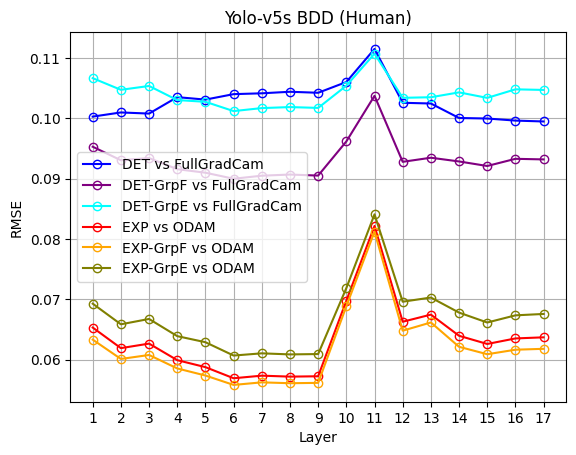

In [16]:
# Vehicle
plt.figure()
for analysis in RMSE_all.keys():
    plt.plot(RMSE_sorted[analysis]['human'].index, RMSE_sorted[analysis]['human'].values, marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
# plt.ylim((0.2,0.8))
plt.xticks(RMSE_sorted[analysis]['human'].index)
plt.grid()
plt.legend()
plt.xlabel('Layer')
plt.ylabel('RMSE')
plt.title("Yolo-v5s BDD (Human)")
plt.show()

Bar Scatter Plot

In [6]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']

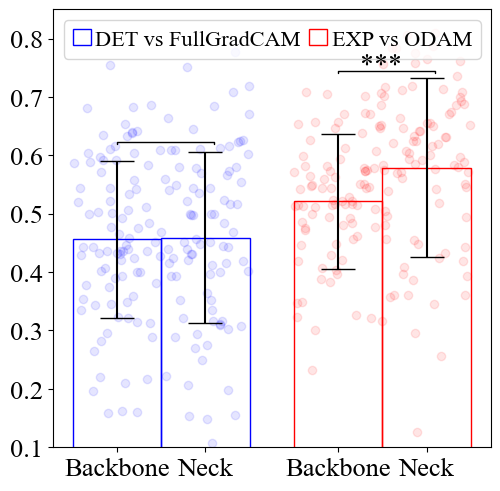

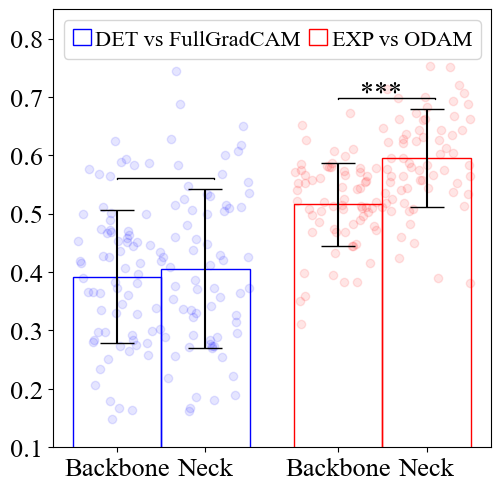

In [47]:
for category in ['vehicle','human']:
    # Bar scatter plot
    # x = np.arange(len(focused_analysis))  # the label locations
    width = 0.4  # the width of the bars
    np.random.seed(123)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 10

    fig, ax = plt.subplots(layout='constrained')

    x_labels = ['Backbone','Neck','Backbone','Neck']
    x_labels_loc = []

    multiplier1 = 0
    offset1 = width * multiplier1

    multiplier2 = 1
    offset2 = width * multiplier2

    # Backbone
    for x, analysis in enumerate(focused_analysis):
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k'))
        rects = ax.bar(x + offset1, 
                    backbone_value,
                    yerr=float(np.format_float_positional(np.std(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')), 
                    capsize=12,
                    width=width, 
                    color=(0,0,0,0), 
                    edgecolor=color_code[analysis], 
                    label=analysis)
        x_labels_loc.append(x+offset1)
        x_labels_loc.append(x+offset2)
        # ax.bar_label(rects, padding=3)

    for x, analysis in enumerate(focused_analysis):
        neck_value = float(np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')),
        rects = ax.bar(x + offset2, 
            neck_value,
            yerr=float(np.format_float_positional(np.std(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')), 
            capsize=12,
            width=width, 
            color=(0,0,0,0), 
            edgecolor=color_code[analysis], 
            label=analysis)
        # ax.bar_label(rects, padding=3)
    
    ax.legend(labels=['DET vs FullGradCAM','EXP vs ODAM'], 
              loc='upper left', ncols=3, 
              fontsize=16,
              handletextpad=0.2,
              columnspacing=0.4,
              handlelength=0.8)

    for x, analysis in enumerate(focused_analysis):
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k'))
        backbone_height = backbone_value + 0.9 * np.std(backbone_pcc[category][analysis])
        neck_value = float(np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')),
        neck_height = neck_value + 0.9 * np.std(neck_pcc[category][analysis])


        if p_values[category][analysis] < 0.001: text = "***"
        elif p_values[category][analysis] < 0.01: text = "**"
        elif p_values[category][analysis] < 0.05: text = "*"
        else: text  = ''       
        def label_diff(i,j,text,X,Y):
            x = (X[i]+X[j])/2
            y = 1.1*max(Y[i], Y[j])
            dx = abs(X[i]-X[j])

            props = {'connectionstyle':'bar','arrowstyle':'-',\
                        'shrinkA':20,'shrinkB':20,'linewidth':1}
            ax.annotate(text, xy=(X[i]*1.1,y*0.94), zorder=10, fontsize=20)
            ax.annotate('', xy=(X[i],y*0.88), xytext=(X[j],y*0.88), arrowprops=props,ha='center')

        label_diff(0,1,text,[x+offset1*0.9,x+offset2*1.1],[backbone_height,neck_height])

    for x, analysis in enumerate(focused_analysis):
        ax.scatter(x + np.random.random(len(backbone_pcc[category][analysis])) * width - width / 2, backbone_pcc[category][analysis], color=color_code[analysis],alpha=0.1)
        ax.scatter(x + offset2 + np.random.random(len(neck_pcc[category][analysis])) * width - width / 2, neck_pcc[category][analysis], color=color_code[analysis],alpha=0.1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('PCC',fontsize=20)
    # ax.set_title(f'Yolo-v5s {category.capitalize()}',fontsize=20)
    ax.set_xticks(x_labels_loc, x_labels)
    ax.tick_params(labelsize=19)
    ax.set_ylim(0.1,0.85)

    ratio = 1
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

    plt.show()
    fig.savefig(f'/mnt/h/jinhan/xai/results/bdd/bdd_{category}_bar_scatter_plot')

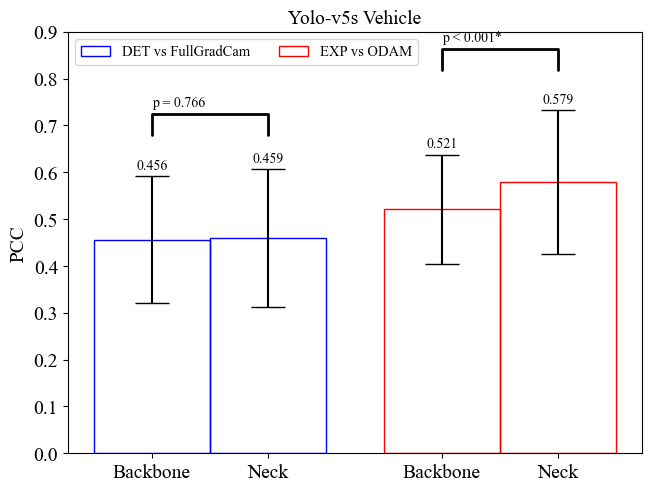

<Figure size 640x480 with 0 Axes>

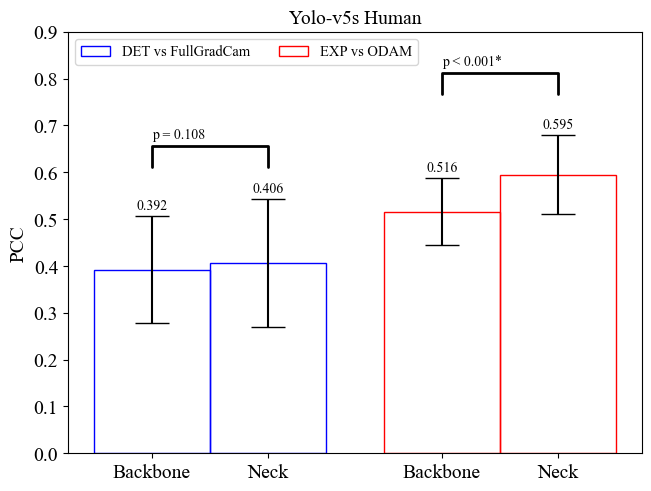

<Figure size 640x480 with 0 Axes>

In [91]:
for category in ['vehicle','human']:
    # Bar scatter plot
    # x = np.arange(len(focused_analysis))  # the label locations
    width = 0.4  # the width of the bars
    np.random.seed(123)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 10

    fig, ax = plt.subplots(layout='constrained')

    x_labels = ['Backbone','Neck','Backbone','Neck']
    x_labels_loc = []

    multiplier1 = 0
    offset1 = width * multiplier1

    multiplier2 = 1
    offset2 = width * multiplier2

    # Backbone
    for x, analysis in enumerate(focused_analysis):
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k'))
        rects = ax.bar(x + offset1, 
                    backbone_value,
                    yerr=float(np.format_float_positional(np.std(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')), 
                    capsize=12,
                    width=width, 
                    color=(0,0,0,0), 
                    edgecolor=color_code[analysis], 
                    label=analysis)
        x_labels_loc.append(x+offset1)
        x_labels_loc.append(x+offset2)
        ax.bar_label(rects, padding=3)

    for x, analysis in enumerate(focused_analysis):
        neck_value = float(np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')),
        rects = ax.bar(x + offset2, 
            neck_value,
            yerr=float(np.format_float_positional(np.std(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')), 
            capsize=12,
            width=width, 
            color=(0,0,0,0), 
            edgecolor=color_code[analysis], 
            label=analysis)
        ax.bar_label(rects, padding=3)
    
    ax.legend(labels=focused_analysis, loc='upper left', ncols=3, fontsize=10.5)

    for x, analysis in enumerate(focused_analysis):
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k'))
        backbone_height = backbone_value + 0.9 * np.std(backbone_pcc[category][analysis])
        neck_value = float(np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')),
        neck_height = neck_value + 0.9 * np.std(neck_pcc[category][analysis])


        if p_values[category][analysis] < 0.001: text = "p < 0.001*"
        elif p_values[category][analysis] < 0.05: text = f"p = {p_values[category][analysis]}*"
        else: text = f"p = {p_values[category][analysis]}"
        def label_diff(i,j,text,X,Y):
            x = (X[i]+X[j])/2
            y = 1.1*max(Y[i], Y[j])
            dx = abs(X[i]-X[j])

            props = {'connectionstyle':'bar','arrowstyle':'-',\
                        'shrinkA':10,'shrinkB':10,'linewidth':2}
            ax.annotate(text, xy=(X[i],y+0.09), zorder=10)
            ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props,ha='center')

        label_diff(0,1,text,[x+offset1,x+offset2],[backbone_height,neck_height])

    # for x, analysis in enumerate(focused_analysis):
    #     ax.scatter(x + np.random.random(len(backbone_pcc[category][analysis])) * width - width / 2, backbone_pcc[category][analysis], color=color_code[analysis],alpha=0.1)
    #     ax.scatter(x + offset2 + np.random.random(len(neck_pcc[category][analysis])) * width - width / 2, neck_pcc[category][analysis], color=color_code[analysis],alpha=0.1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('PCC',fontsize=14)
    ax.set_title(f'Yolo-v5s {category.capitalize()}',fontsize=14)
    ax.set_xticks(x_labels_loc, x_labels)
    ax.tick_params(labelsize=14)
    ax.set_ylim(top=0.9)

    plt.show()
    plt.savefig(f'/mnt/h/jinhan/xai/results/bdd/bdd_{category}_bar_scatter_plot')

## Clustering

In [2]:
PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/faster_rcnn/bdd_PCC_all.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/faster_rcnn/bdd_PCC_all.pickle','rb'))

In [14]:
from sklearn.cluster import KMeans

focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']
dfs = defaultdict(defaultdict)
PCC_mean = defaultdict(defaultdict)

for category in ['vehicle','human']:

    # reverse layer numbering
    for analysis in focused_analysis:
        df = pd.DataFrame.from_dict(PCC_all[analysis][category])
        
        dfs[analysis][category] = df.T
        PCC_mean[analysis][category] = df.T.mean(axis=1)

In [15]:
import logging
def init_logger(filename, debug=False):
    level = logging.DEBUG if debug else logging.INFO
    logger = logging.getLogger()
    handler = logging.FileHandler(filename=filename)
    formatter = logging.Formatter(
        "%(asctime)s %(name)s %(lineno)s [%(levelname)s] %(message)s",
        datefmt='%Y/%m/%d %H:%M:%S'
    )

    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(level)
    return logger

from collections import Counter

# Renumber cluster idx for better visualization
# turn [1,1,0,4,0,2,1] into [0,0,1,2,1,3,0]
def relabel_clusters(arr):
    counter = Counter(arr)
    return [list(counter.keys()).index(num) for num in arr]

In [16]:
cluster_labels = [
"o",
"v",
"s",
# "*",
"X",
"d",
"p",
"^",
"<",
">",
"D",
"P",
"8",
"h",
]

def find_high_sim_layers(df, labels):
    if type(labels) != 'numpy.ndarray':
        labels = np.array(labels)
    layers = np.asarray(df.index)
    k = len(set(labels))
    max_k = 0

    cluster_mean = {}

    max = 0
    max_layers = {}
    for k in set(labels):
        layers = np.asarray(df.index)[labels == k]
        cluster_mean[k] = df.loc[list(layers)].mean().mean()
        if cluster_mean[k] > max: 
            max = cluster_mean[k]
            max_layers = layers
            max_k = k
    return max_layers, max_k

### Agglomerative (Hierarchical)

In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time, pickle
import itertools
from itertools import chain

hyperparameters = {
'n_clusters': [None],
'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
#connectivity?
'linkage': ['ward', 'complete', 'average', 'single'],
}
keys, values = zip(*hyperparameters.items())
param_grid = [(idx, dict(zip(keys, v))) for idx, v in enumerate(itertools.product(*values))]
print(len(param_grid))

20


In [18]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Failed to fit human EXP vs ODAM	4	{'n_clusters': None, 'metric': 'l1', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	8	{'n_clusters': None, 'metric': 'l2', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	12	{'n_clusters': None, 'metric': 'manhattan', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	16	{'n_clusters': None, 'metric': 'cosine', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	4	{'n_clusters': None, 'metric': 'l1', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	8	{'n_clusters': None, 'metric': 'l2', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	12	{'n_clusters': None, 'metric': 'manhattan', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	16	{'n_clusters': None, 'metric': 'cosine', 'linkage': 'ward', 'distance_threshold': 0}
Failed to fit human EXP vs ODAM	4	{'n_clusters': None,

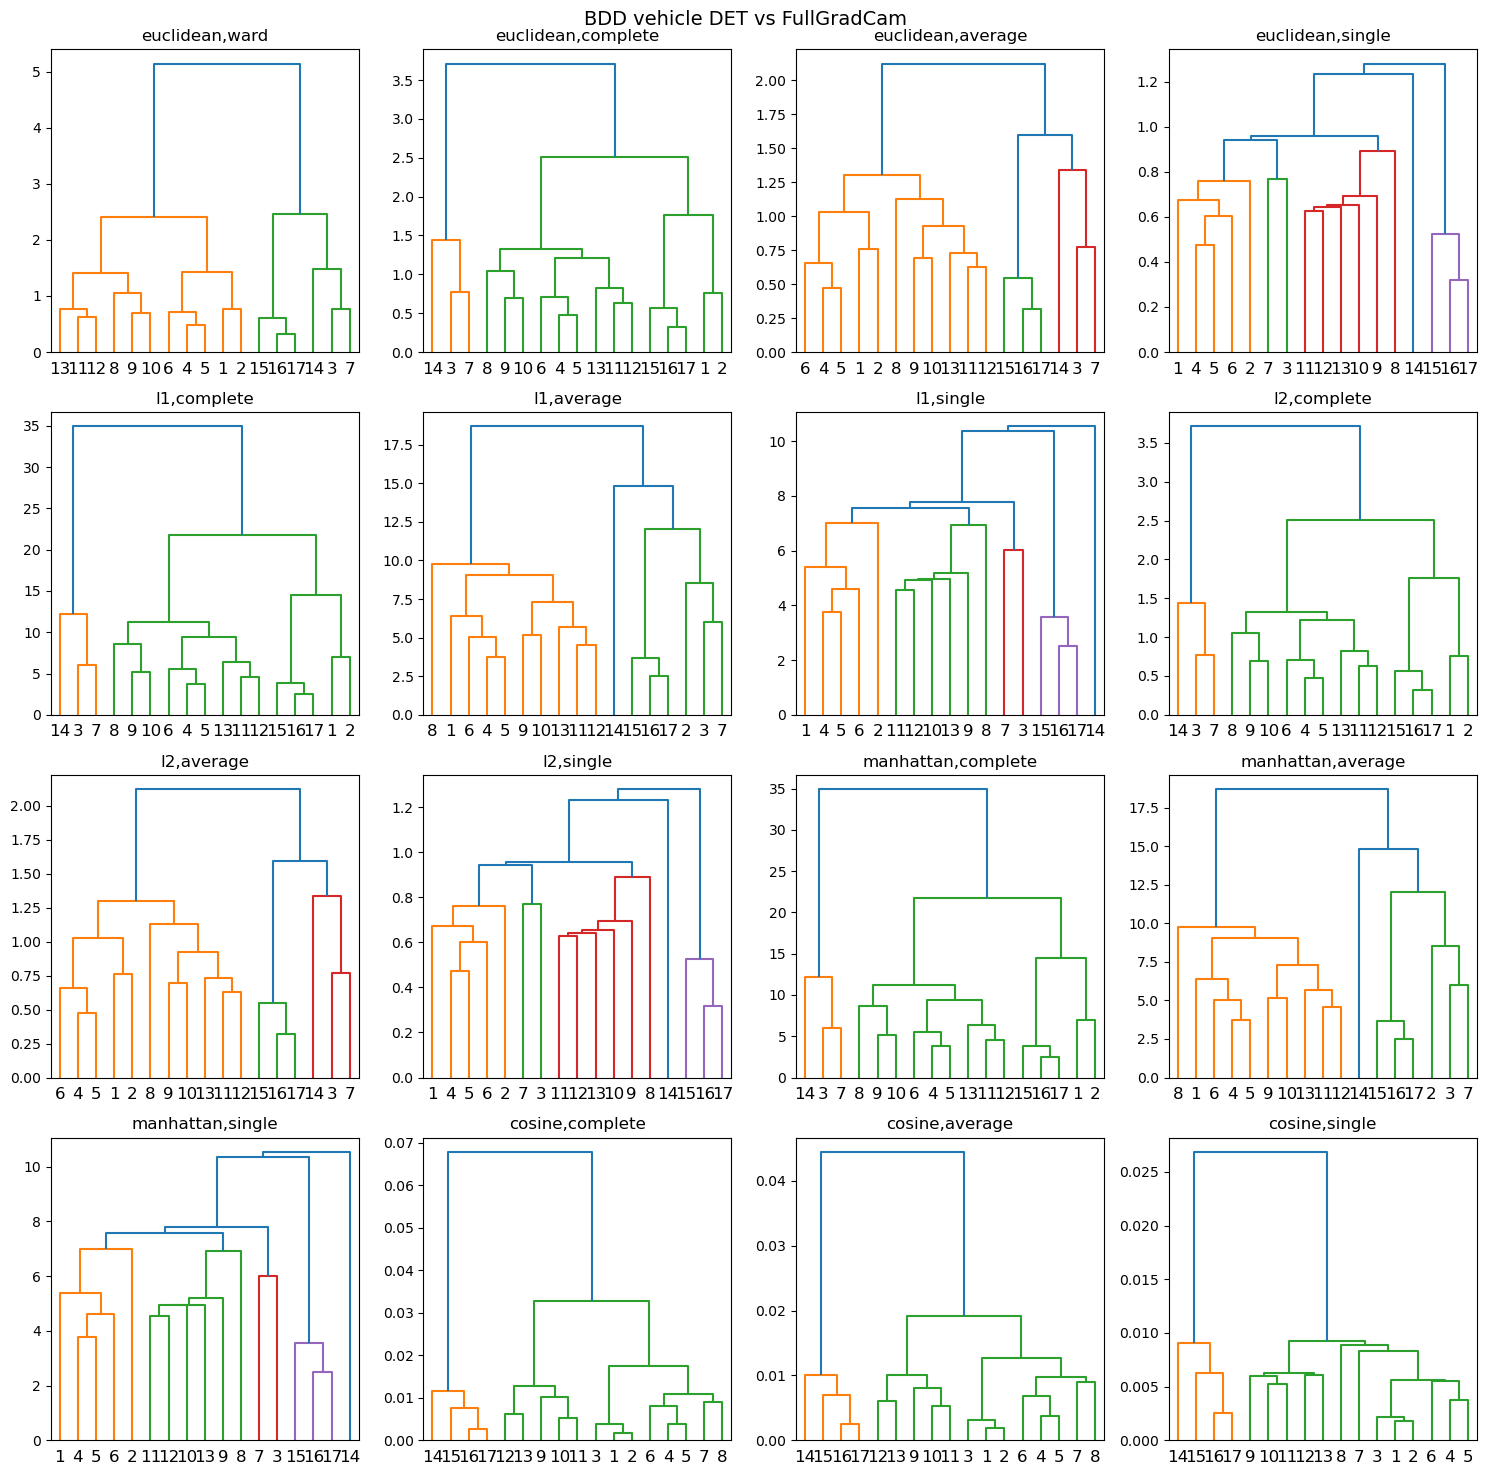

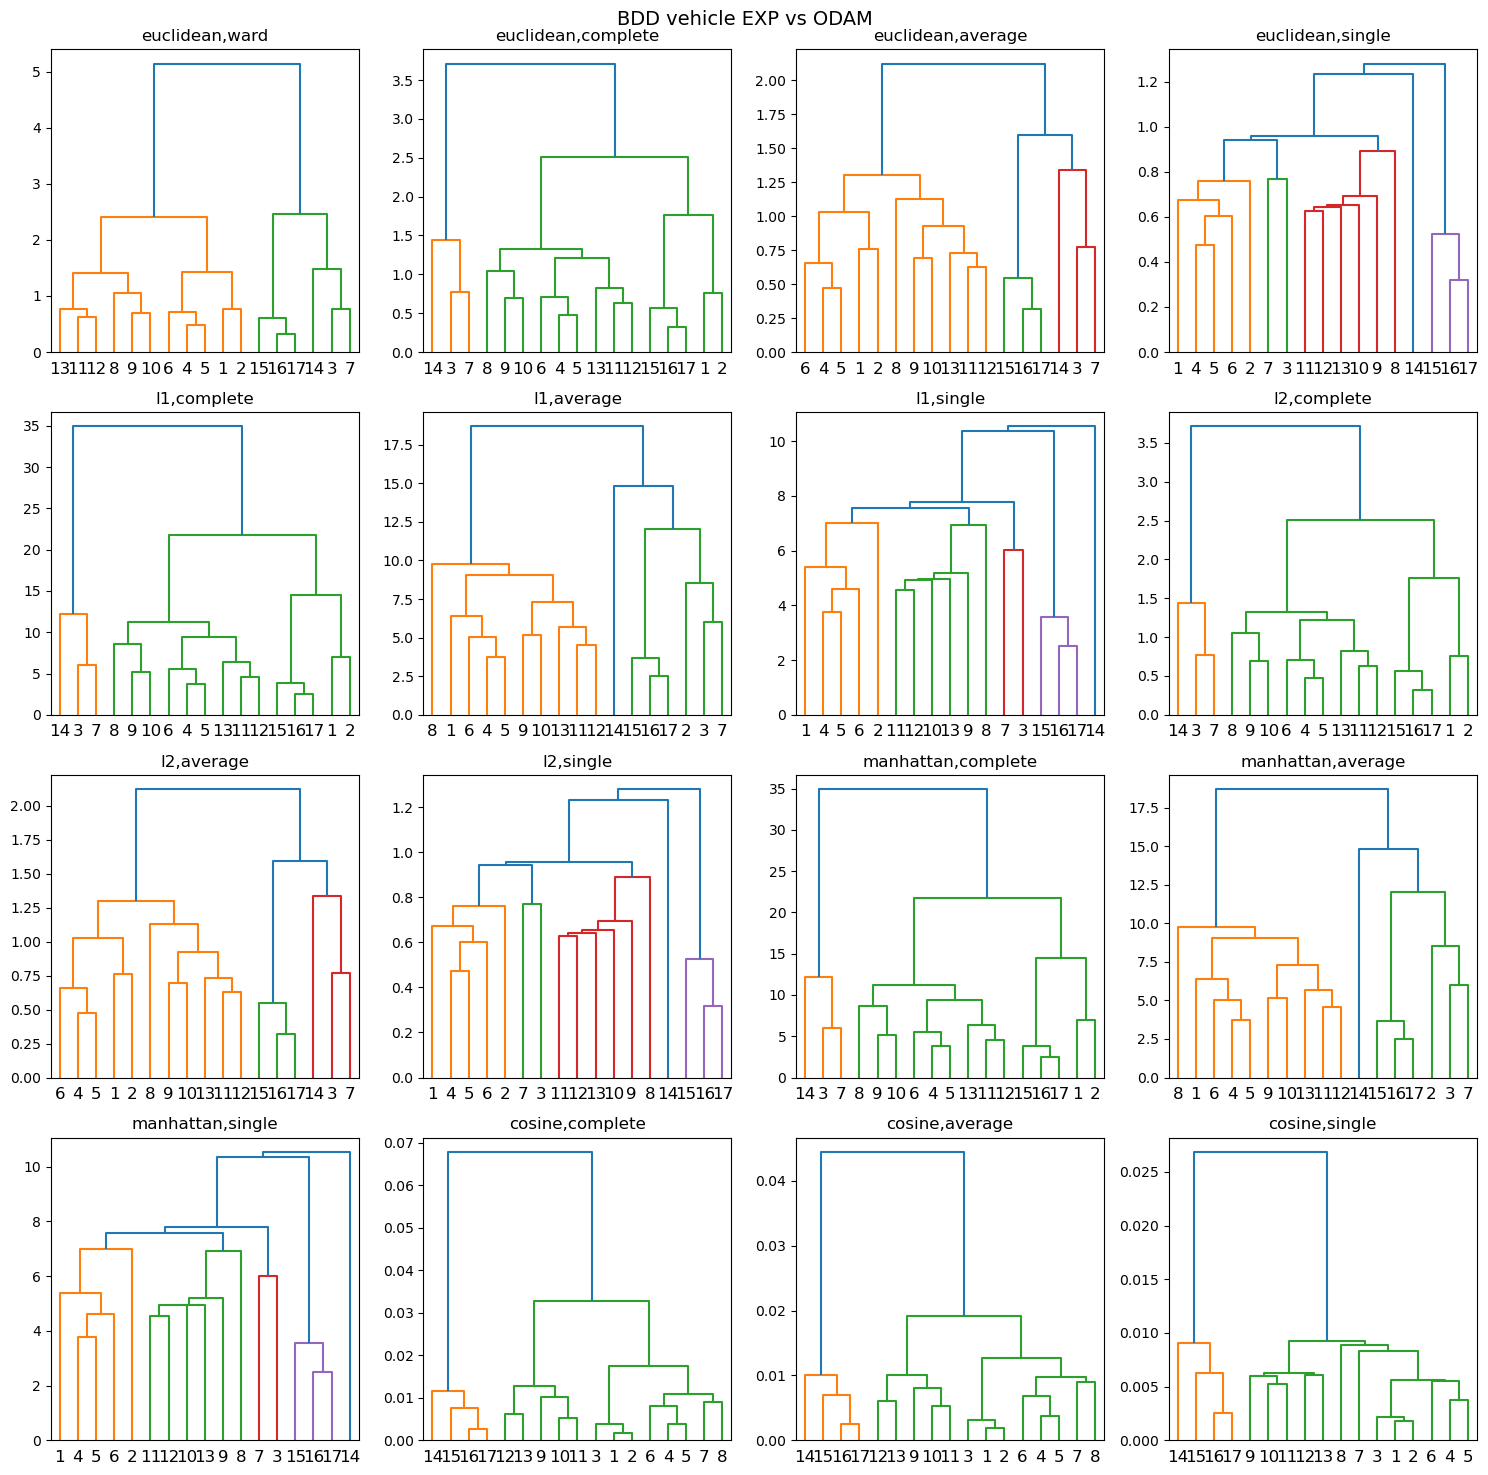

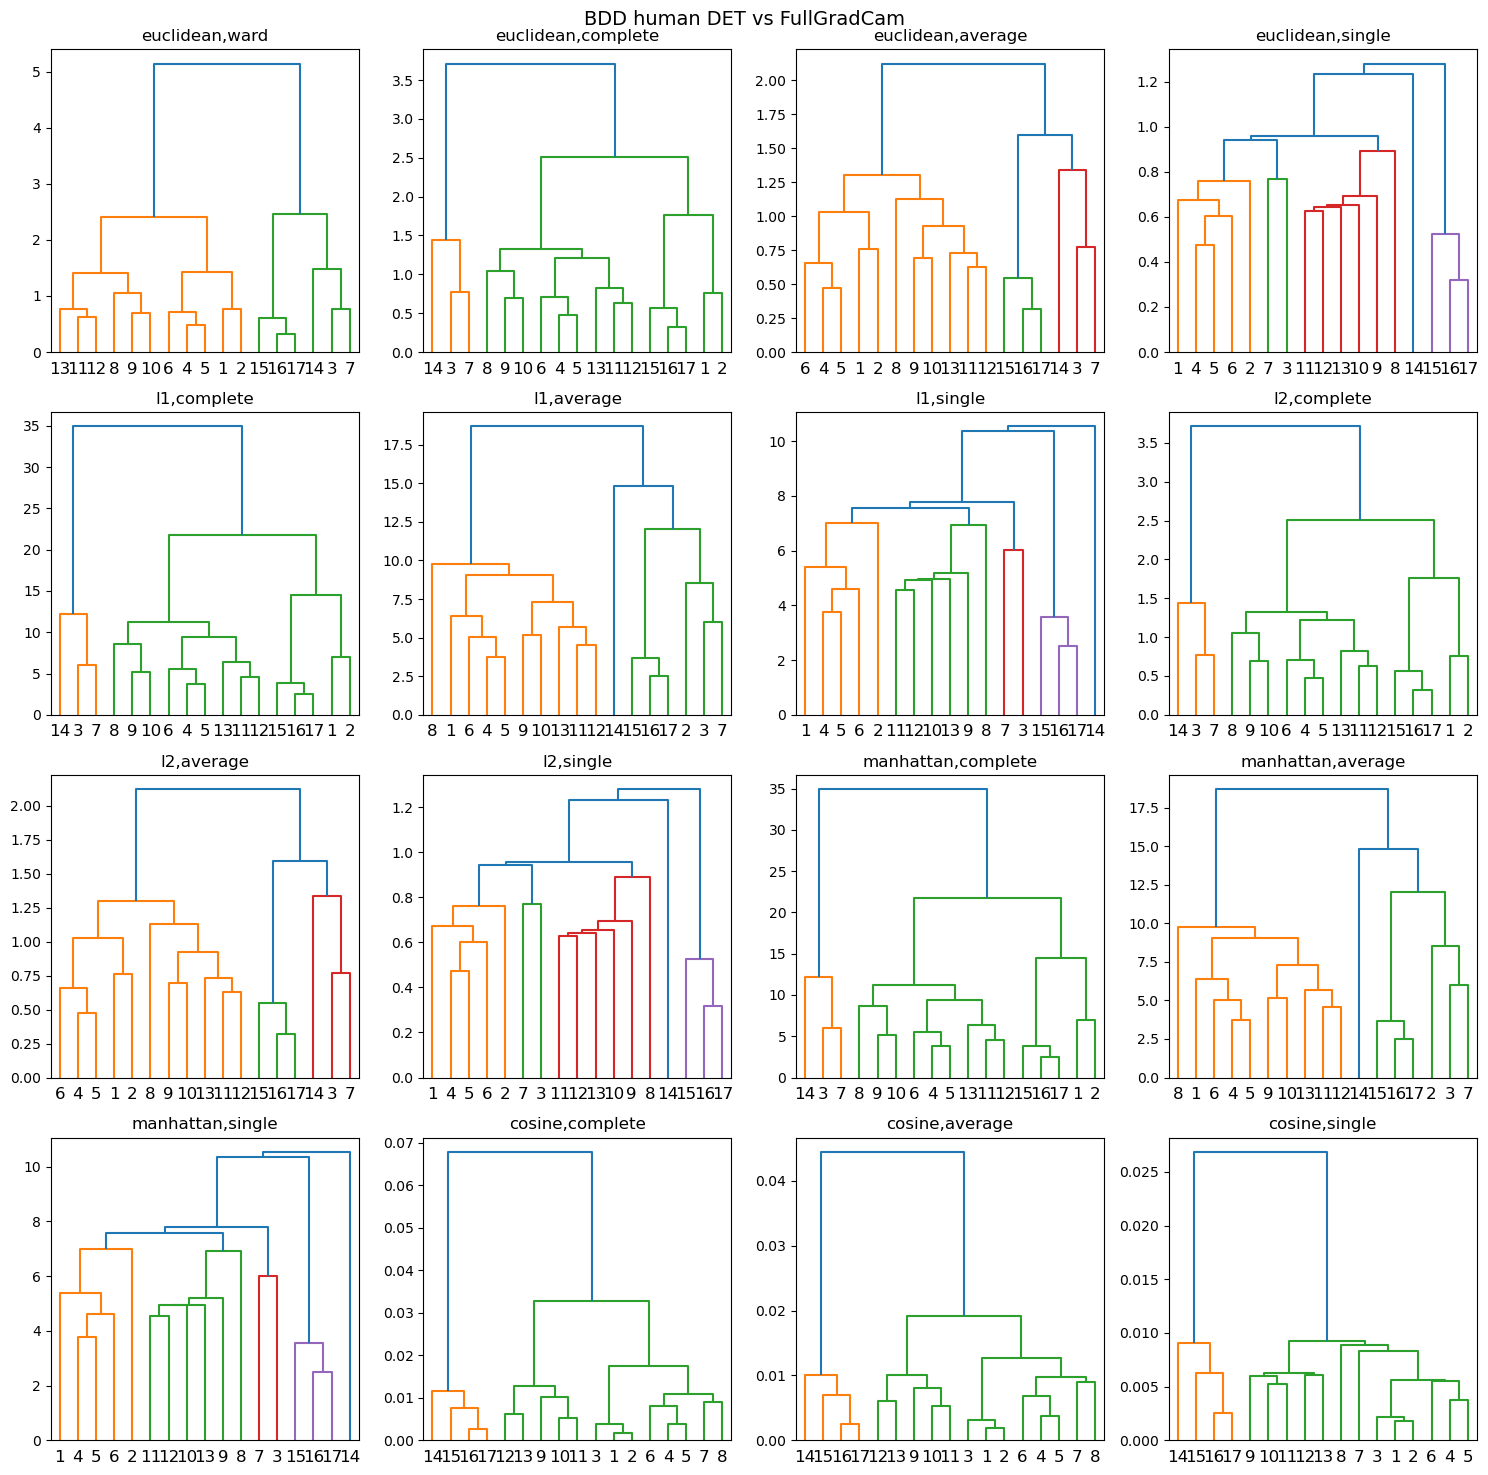

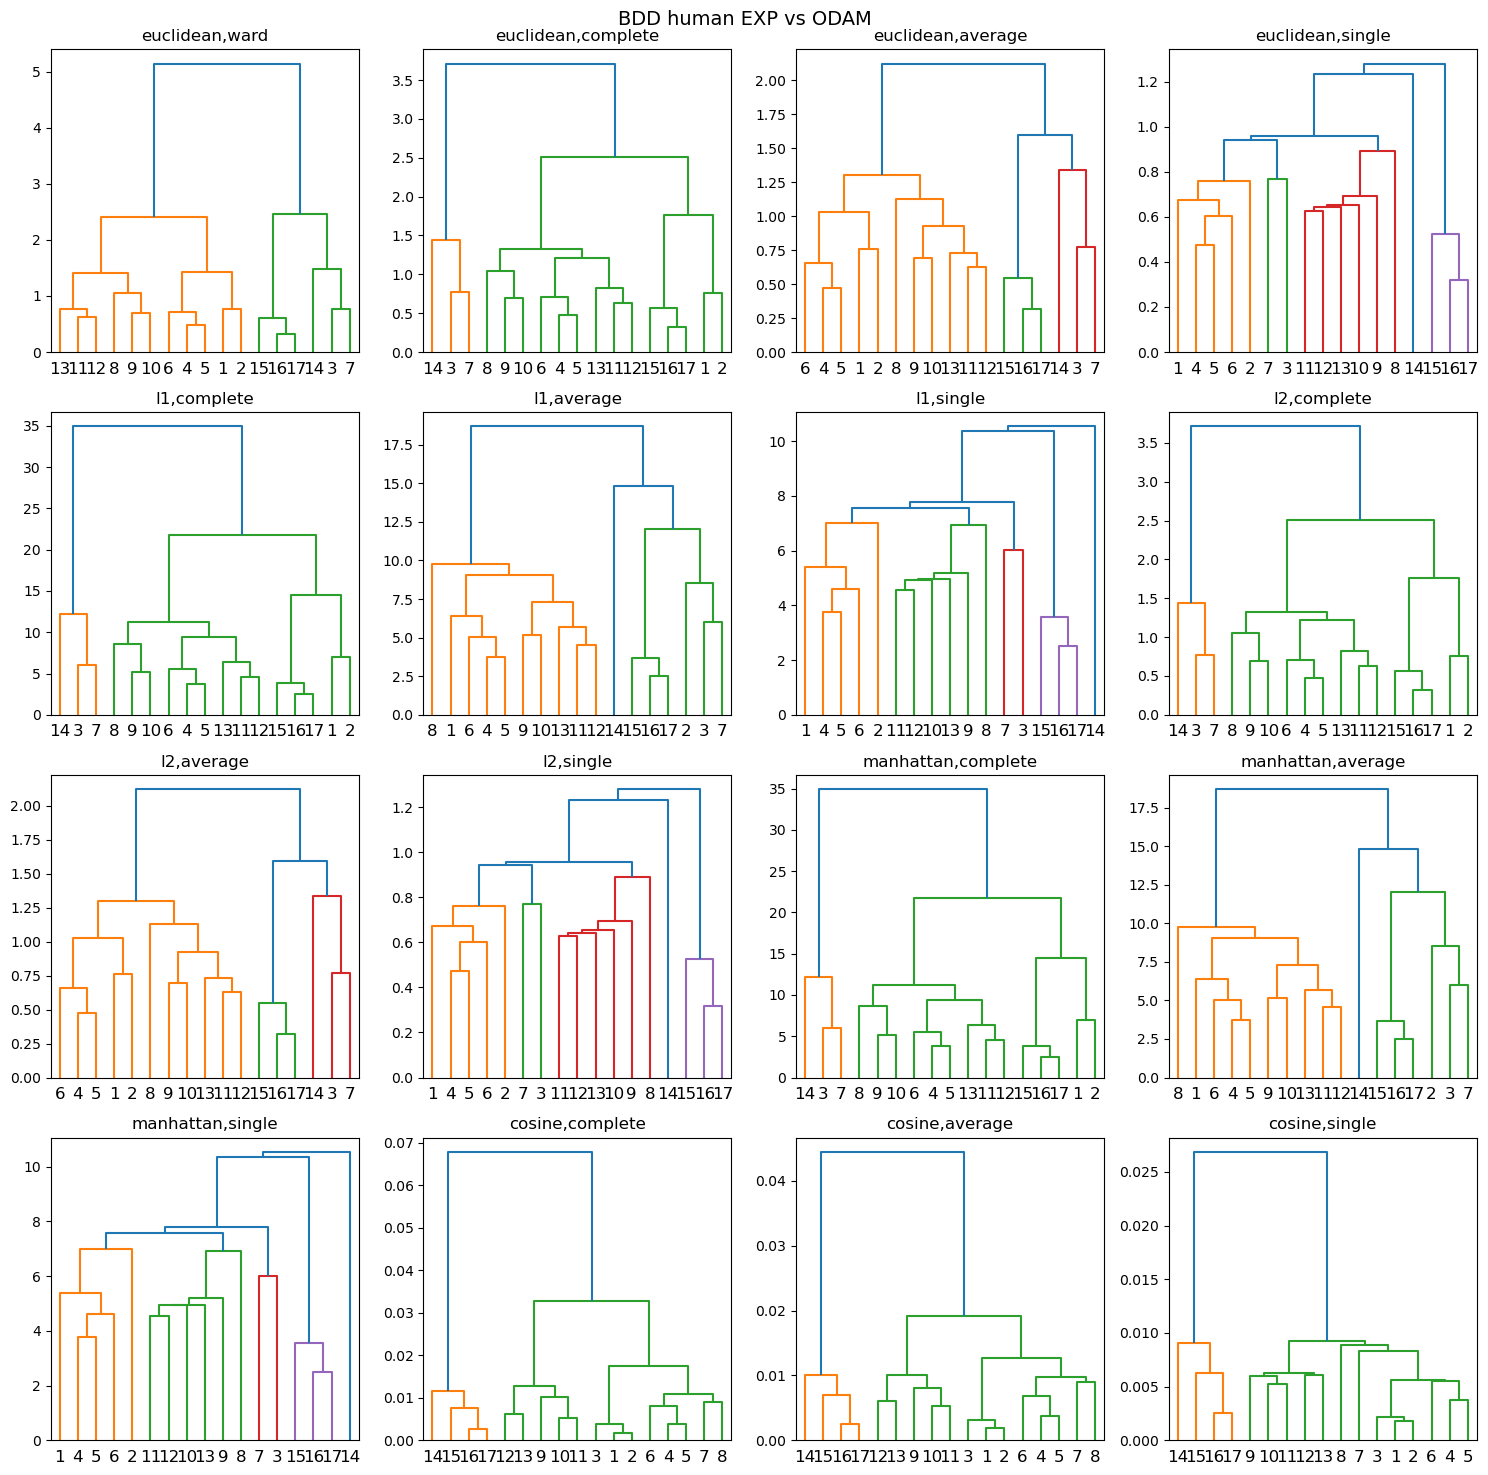

In [29]:
import time, sys

sys.tracebacklimit = 0


def fit_model(ax, category, analysis, idx, params):

    start = time.time()

    analysis = 'EXP vs ODAM'
    category = 'human'

    # data = dfs[analysis][category]
    if category == 'vehicle':
        data = dfs[analysis][category].drop(columns=['611','727','1112'])
    elif category == 'human':
        data = dfs[analysis][category].drop(columns=['1538','286','380'])

    if not params['n_clusters']:
        params['distance_threshold'] = 0 # make sure we compute the full tree

    try:

        model = AgglomerativeClustering(compute_distances=True,
                                        **params
                                        )
        labels = model.fit_predict(data)
        plot_dendrogram(model, ax=ax,truncate_mode="level", labels=np.arange(1,18))
        ax.set_title(f"{params['metric']},{params['linkage']}")

        end = time.time()

        res = [{"analysis":analysis,
                **params,
                "labels":labels,
                "distances":model.distances_,
                "time(s)":end-start}]

        return res

    except Exception:
        print(f"Failed to fit {category} {analysis}\t{idx}\t{str(params)}")

        end = time.time()

        return None

for category in ['vehicle','human']:
    for analysis in focused_analysis:
        fig, axs = plt.subplots(nrows=4, ncols=4,figsize=[15,15])
        idx = 0
        for params in param_grid:
            res = fit_model(axs[int(idx/4)][int(idx%4)],category,analysis,params[0],params[1])
            if res != None: idx += 1
        fig.suptitle(f"BDD {category} {analysis}",fontsize=14)
        plt.tight_layout()
        plt.draw()

#### Membership Analysis

In [30]:
membership = {
    'vehicle':{
        'DET vs FullGradCam' : [(1,2,4,5,13,11,12,8,9,10,6),(15,16,17,3,7)], 
        'EXP vs ODAM' : [(13,11,12,8,9,10,6,4,5,1,2),(15,16,17,14,3,7)], 
    },
    'human':{
        'DET vs FullGradCam' : [(1,2,4,5,13,11,12,8,9,10,6),(15,16,17,3,7)], 
        'EXP vs ODAM' : [(13,11,12,8,9,10,6,4,5,1,2),(15,16,17,14,3,7)], 
    }
}

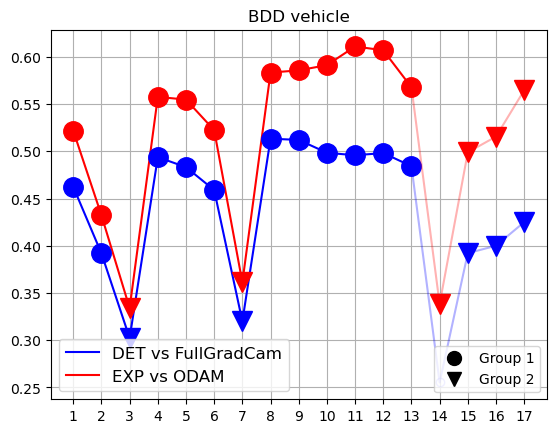

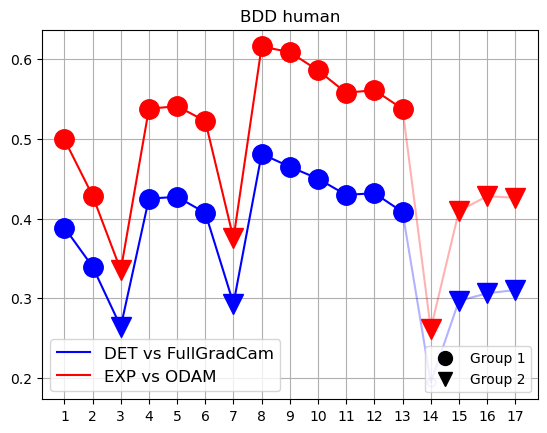

In [31]:
import matplotlib.lines as mlines
# Overall similarity

for category in ['vehicle','human']:

    plt.figure()
    plt.grid()
    ax = plt.gca()
    # plt.xlabel('Layer')
    # plt.ylabel('PCC')
    for analysis in focused_analysis:
        plt.plot(PCC_mean[analysis][category].index[0:13].values, PCC_mean[analysis][category].values[0:13],label=analysis,c=color_code[analysis])
        plt.xticks(PCC_mean[analysis][category].index)
        # plt.ylim(ylims)
        # plt.title(f"Yolo-v5s MSCOCO")

    legend1 = plt.legend(fontsize=12, loc=0)
    ax.add_artist(legend1)

    for analysis in focused_analysis:
        # print(labels[analysis])
        for i, group in enumerate(membership[category][analysis]):
            marker = cluster_labels[i]
            for l in group:
                plt.plot(l,PCC_mean[analysis][category][l],marker=marker,c=color_code[analysis],markersize=14)

        plt.plot(PCC_mean[analysis][category].index[12:18].values, PCC_mean[analysis][category].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)

    group1_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[0], linestyle='None',
                            markersize=10, label='Group 1')
    group2_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[1], linestyle='None',
                            markersize=10, label='Group 2')
    handles = [group1_marker, group2_marker]

    if len(membership[category][analysis]) == 3:
        group3_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[2], linestyle='None',
                                markersize=10, label='Group 3')
        handles.append(group3_marker)

    legend2=plt.legend(handles=handles,loc=4)

    plt.title(f"BDD {category}")
    plt.show()
